In [1]:
from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/drive/MyDrive/enose/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

Found GPU at: /device:GPU:0


# Read Data

Read each sample csv data and stack it into a dataset. The dataset contains N samples evenly distributed as 'Irrigada' and 'Nao_irriga'.
The dataset is then evenly split into training, validation and testing sets at 70% 10% 20% ratio respectively.

In [ ]:
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy

def read_files(dir):
    positives = []
    negatives = []
    # read all file in the directory
    for file in listdir(dir):
        if isfile(join(dir, file)) and file[-3:] == "csv":
            raw_data = pd.read_csv(join(dir, file), index_col=0, header=None).to_numpy()
            raw_data = np.expand_dims(raw_data, axis=0)

            # check
            if file[1:4] == "Nao":
                negatives.append(raw_data)
            else:
                positives.append(raw_data)

    negatives = np.concatenate(negatives, axis=0)
    for sample in range(negatives.shape[0]):
        for channel in range(negatives.shape[2]):
            signal = negatives[sample, :, channel][:, np.newaxis]
            negatives[sample, :, channel] = MinMaxScaler().fit_transform(signal)[:, 0]

    positives = np.concatenate(positives, axis=0)
    for sample in range(positives.shape[0]):
        for channel in range(negatives.shape[2]):
            signal = positives[sample, :, channel][:, np.newaxis]
            positives[sample, :, channel] = MinMaxScaler().fit_transform(signal)[:, 0]

    return positives, negatives

def create_dataset(data_files):
    # balance data samples
    positives, negatives = data_files
    positives, negatives = positives[:min(positives.shape[0], negatives.shape[0]), :, :], negatives[:min(positives.shape[0], negatives.shape[0]), :, :]

    # create the target values
    target_positives = np.concatenate([np.array([[1, 0]]) for _ in range(positives.shape[0])], axis=0)
    target_negatives = np.concatenate([np.array([[0, 1]]) for _ in range(negatives.shape[0])], axis=0)

    # split into training, validation and test
    positives_train, positives_test, target_positives_train, target_positives_test = train_test_split(positives, target_positives, test_size=0.2)
    positives_train, positives_validation, target_positives_train, target_positives_validation = train_test_split(positives_train, target_positives_train, test_size=0.25)

    negatives_train, negatives_test, target_negatives_train, target_negatives_test = train_test_split(negatives, target_negatives, test_size=0.2)
    negatives_train, negatives_validation, target_negatives_train, target_negatives_validation = train_test_split(negatives_train, target_negatives_train, test_size=0.25)

    datasets = (
        (np.concatenate([positives_train, negatives_train], axis=0), np.concatenate([target_positives_train, target_negatives_train], axis=0)),
        (np.concatenate([positives_validation, negatives_validation], axis=0), np.concatenate([target_positives_validation, target_negatives_validation], axis=0)),
        (np.concatenate([positives_test, negatives_test], axis=0), np.concatenate([target_positives_test, target_negatives_test], axis=0)),
    )

    return datasets

train_data, validation_data, test_data = create_dataset(read_files(datadir))
with open(join(datadir, "train_dataset.pkl"), 'wb') as file_pi:
    pickle.dump(train_data, file_pi)

with open(join(datadir, "validation_dataset.pkl"), 'wb') as file_pi:
    pickle.dump(validation_data, file_pi)

with open(join(datadir, "test_dataset.pkl"), 'wb') as file_pi:
    pickle.dump(test_data, file_pi)

print(train_data[0].shape)
print(validation_data[0].shape)
print(test_data[0].shape)

(180, 241, 6)
(62, 241, 6)
(62, 241, 6)


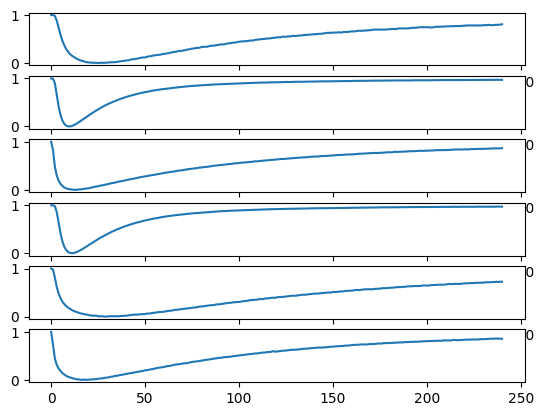

In [ ]:
from matplotlib import pyplot as plt

sample = 91
fig, axs = plt.subplots(6, 1)
plt.plot()
for i, ax in enumerate(axs):
    ax.plot(range(train_data[0].shape[1]), train_data[0][sample, :, i])



In [ ]:
def create_model(input_shape):
    model = keras.Sequential([keras.Input(shape=input_shape)])

    model.add(layers.Conv1D(filters=16,kernel_size=5,strides=1,activation='relu',padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.15))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(filters=16,kernel_size=5,strides=1,activation='relu',padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.15))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(filters=32,kernel_size=9,strides=1,activation='relu',padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling1D(2))



    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="sigmoid", kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation="softmax", kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))

    opt = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.Accuracy()])
    return model


model = create_model((241, 6))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 241, 16)           496       
                                                                 
 batch_normalization (Batch  (None, 241, 16)           64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 241, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 120, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 16)           1296      
                                                                 
 batch_normalization_1 (Bat  (None, 120, 16)           6

In [ ]:
from os.path import isfile, join
import pickle

history = model.fit(
    x=train_data[0],
    y=train_data[1],
    batch_size=32,
    epochs=150,
    verbose="auto",
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=20),],
    validation_data=validation_data,
    shuffle=True,
)

model.save(join(datadir, "model.keras"))
with open(join(datadir, "history.pkl"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


In [3]:
from os.path import join
import pickle

saved_dir = "./Modelos/"
model = tf.keras.models.load_model(join(saved_dir, "model_saved.keras"))
with open(join(saved_dir, "history_saved.pkl"), 'rb') as file_pi:
    history = pickle.load(file_pi)
with open(join(saved_dir, "train_dataset_saved.pkl"), 'rb') as file_pi:
    train_data = pickle.load(file_pi)
with open(join(saved_dir, "validation_dataset_saved.pkl"), 'rb') as file_pi:
    validation_data = pickle.load(file_pi)
with open(join(saved_dir, "test_dataset_saved.pkl"), 'rb') as file_pi:
    test_data = pickle.load(file_pi)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 241, 16)           496       
                                                                 
 batch_normalization (Batch  (None, 241, 16)           64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 241, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 120, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 16)           1296      
                                                                 
 batch_normalization_1 (Bat  (None, 120, 16)           6

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

decoder = OneHotEncoder().fit([["Irrigada"], ["Nao_Irrigada"]])

train_accuracy = accuracy_score(decoder.inverse_transform(train_data[1]), decoder.inverse_transform(model.predict(train_data[0])))
validation_accuracy = accuracy_score(decoder.inverse_transform(validation_data[1]), decoder.inverse_transform(model.predict(validation_data[0])))
test_accuracy = accuracy_score(decoder.inverse_transform(test_data[1]), decoder.inverse_transform(model.predict(test_data[0])))
loss = keras.losses.CategoricalCrossentropy()(train_data[1], model.predict(train_data[0]))


print(f"Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}, Test Accuracy: {test_accuracy}, Loss: {loss}")


6/6 [==============================] - 0s 3ms/step
Train Accuracy: 0.9222222222222223, Validation Accuracy: 0.8225806451612904, Test Accuracy: 0.967741935483871, Loss: 0.21508212387561798


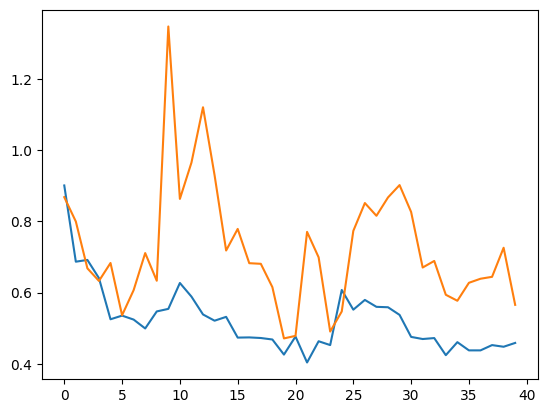

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(history["loss"])), history["loss"], range(len(history["val_loss"])), history["val_loss"])
plt.show()